In [28]:
import pandahouse
import seaborn as sns
from scipy import stats

In [29]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT distinct user_id, exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220820.feed_actions
WHERE toDate(time) >= '2022-07-13' and toDate(time) <= '2022-07-19'
GROUP BY user_id, exp_group
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [30]:
# Шаг 1. В контрольных группах считаем общий CTR

global_ctr_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()


In [31]:
# Шаг 2. В каждой группе считаем метрику линеаризованных лайков

def get_lin_likes(user_likes, user_views, global_ctr):
    lin_likes = user_likes - global_ctr * user_views
    return lin_likes

group0 = df[df.exp_group == 0].copy()
group0['lin_likes'] = df.apply(
    lambda x: get_lin_likes(x['likes'], x['views'], global_ctr_0), axis=1)

group1 = df[df.exp_group == 1].copy()
group1['lin_likes'] = df.apply(
    lambda x: get_lin_likes(x['likes'], x['views'], global_ctr_1), axis=1)

group2 = df[df.exp_group == 2].copy()
group2['lin_likes'] = df.apply(
    lambda x: get_lin_likes(x['likes'], x['views'], global_ctr_1), axis=1)

group3 = df[df.exp_group == 3].copy()
group3['lin_likes'] = df.apply(
    lambda x: get_lin_likes(x['likes'], x['views'], global_ctr_0), axis=1)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)


<AxesSubplot:xlabel='lin_likes'>

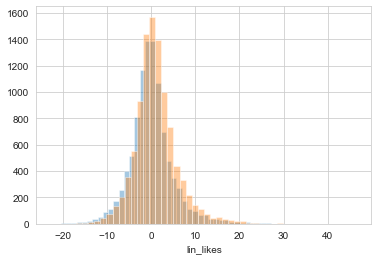

In [42]:
# Шаг 3. Выполняем t-test на группах 0 и 3, сравниваем тест на лин.лайках с тестом на CTR

print(stats.ttest_ind(group0['lin_likes'],
                group3['lin_likes'],
                equal_var=False))

sns.distplot(group0.lin_likes,
             kde = False)
sns.distplot(group3.lin_likes,
             kde = False)

In [36]:
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

# По группам 0 и 3 по обеим метрикам p-value очень близок к 0

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)


<AxesSubplot:xlabel='lin_likes'>

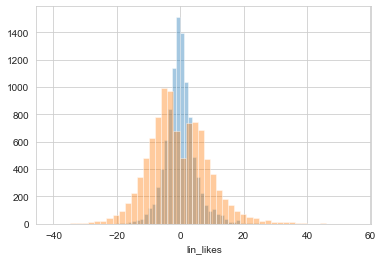

In [41]:
# Выполняем t-test на группах 1 и 2, сравниваем тест на лин.лайках с тестом на CTR

print(stats.ttest_ind(group1['lin_likes'],
                group2['lin_likes'],
                equal_var=False))

sns.distplot(group1.lin_likes,
             kde = False)
sns.distplot(group2.lin_likes,
             kde = False)

In [39]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

# По группам 1 и 2 по обеим метрикам p-value различается. По метрике лин.лайков p-value очень близок к 0, а по CTR p-value=0.48, что приводит к разным результатам теста

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Итог: для групп 1 и 2 разница в p-value оказалась критичной и повлияла на результаты теста. Тест по линеаризованным лайкам показал более достоверный результат (что подтверждают проведенные тесты из задания 2).